In [1]:
############################
############################
#
#    I wrote this code to reproduce the results of the paper "Flow-Driven Branching in a Frangible Porous Medium", by Derr et al.
#    Link: https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.125.158002
#    DOI: https://doi.org/10.1103/PhysRevLett.125.158002
#
############################
############################

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp2d


from mpi4py import MPI
import dolfinx as dx
import ufl

from dolfinx.fem.petsc import LinearProblem
import pyvista

import time
import os

In [3]:
###
#
#   In this section the mesh, the functionspaces and the boundaries are set up for later.
#
###

# Specify grid size to be n x n.
n = 300

# Boundary length of quadratic domain, so the domain will have shape [0,bx] x [0,bx].
bx = 10
grid_spacing = bx/n

# Initialize Domain
domain = dx.mesh.create_rectangle(MPI.COMM_WORLD, [np.array([0, 0]), np.array([bx, bx])], [n, n], dx.mesh.CellType.quadrilateral)

# Initialize Functionspace and test/trial functions.
V = dx.fem.functionspace(domain, ("Lagrange", 1))
u = ufl.TrialFunction(V)
v = ufl.TestFunction(V)

# Define the boundaries. The top and bottom boundaries have no flux passing through them.
# epsilon_lh and epislon_rh are the half widths of the regions of the boundaries with flux passing through.
# These regions are centered on the left-hand (lh) and right-hand (rh) side. 
# For now, this just defines different regions of the boundaries, the assignment of the specific fluxes for each segment wil follow.
epsilon_lh = 0.2 # pointsource
epsilon_rh = 4.5 # pointsink
boundaries = [
    (1, lambda x: np.isclose(x[0], 0)),
    (2, lambda x: np.isclose(x[0], bx)),
    (3, lambda x: np.isclose(x[1], 0) & (bx/2 - epsilon_lh <= x[0]) & (x[0] <= bx/2 + epsilon_lh)),
    (4, lambda x: np.isclose(x[1], 0) & ((x[0] < bx/2 - epsilon_lh) | (x[0] > bx/2 + epsilon_lh))),
    (5, lambda x: np.isclose(x[1], bx) & (bx/2 - epsilon_rh <= x[0]) & (x[0] <= bx/2 + epsilon_rh)),
    (6, lambda x: np.isclose(x[1], bx) & ((x[0] < bx/2 - epsilon_rh) | (x[0] > bx/2 + epsilon_rh))),
]

# Initialize measure for custom boundary defined above.
facet_indices, facet_markers = [], []
fdim = domain.topology.dim - 1
for (marker, locator) in boundaries:
    facets = dx.mesh.locate_entities(domain, fdim, locator)
    facet_indices.append(facets)
    facet_markers.append(np.full_like(facets, marker))
facet_indices = np.hstack(facet_indices).astype(np.int32)
facet_markers = np.hstack(facet_markers).astype(np.int32)
sorted_facets = np.argsort(facet_indices)
facet_tag = dx.mesh.meshtags(domain, fdim, facet_indices[sorted_facets], facet_markers[sorted_facets])

ds = ufl.Measure("ds", domain=domain, subdomain_data=facet_tag)

In [4]:
###
#
#   This section simply defines a function to get the initial state of phi at t = 0 as described in eq.6 in the erosion paper.
#
###

# Define the parameters
phi_0 = 0.8       # mean of the Gaussian noise
sigma_phi = 0.05  # variance of the Gaussian noise
zeta = 0.15  # correlation length
grid_size = n  # size of the grid


def generate_phi0(toplot=False):
    # Calculate the wave numbers
    kx = 2 * np.pi * np.fft.fftfreq(grid_size, d=grid_spacing)
    ky = 2 * np.pi * np.fft.fftfreq(grid_size, d=grid_spacing)
    KX, KY = np.meshgrid(kx, ky)

    # Calculate the power spectrum
    K_sq = KX**2 + KY**2
    spectrum = np.exp(-0.25 * K_sq * zeta**2)

    # Generate white noise in Fourier space
    white_noise = np.random.normal(0, 1, (grid_size, grid_size)) + 1j * np.random.normal(0, 1, (grid_size, grid_size))

    # Apply the power spectrum to the white noise
    colored_noise_f = white_noise * np.sqrt(spectrum)

    # Inverse Fourier transform to get the correlated noise in real space
    colored_noise = np.fft.ifft2(colored_noise_f).real

    # Normalize the noise
    colored_noise = colored_noise / np.std(colored_noise) * sigma_phi

    # Add the noise to the constant background
    phi = phi_0 + colored_noise
    if toplot:
        plt.figure()
        plt.imshow(phi, extent=(0, bx, 0, bx), origin='lower', cmap='viridis')
        plt.colorbar(label='phi')
        plt.title('Initial Condition of phi')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.show()
        
    # Make sure that the initial state for phi is in [0,1] everywhere (such that it is physical).
    return np.clip(phi, 0, 1)

In [5]:
###
#
#   In this section I construct the function convolve_optimized, which performs the convolution described in eqs.54-58 in the SI of the erosion paper.
#
###

xi = 0.05
extent = int(3 * xi / grid_spacing)  # 3 sigma on each side

# This function generates B_mat, which is the kernel with which the porosity \phi is convoluted.
def generate_B():
    x_range = np.linspace(-extent*grid_spacing,+extent*grid_spacing,2*extent+1)
    term1 = np.exp(-x_range**2/(2*xi**2))
    c_normalize = 1/np.sum(term1)
    term1 = c_normalize * term1
    mat1, mat2 = np.meshgrid(term1,term1)
    B = mat1 * mat2
    return B

B_mat = generate_B()
B_mat = np.flip(np.flip(B_mat,axis=0),axis=1)

from scipy.signal import fftconvolve

def convolve_optimized(A):
    # padding dimensions
    pad_height = extent
    pad_width = extent

    # Pad the array with reflected boundary elements. 
    # Here the padding is very important: padding with 1's or 0's everywhere lead to numerical instabilities.
    # The instabilities were either too much or to little erosion at the boundaries.
    A_padded = np.pad(A, ((pad_height, pad_height), (pad_width, pad_width)), mode='reflect')

    # Perform FFT-based convolution
    output = fftconvolve(A_padded, B_mat, mode='valid')  # 'valid' because we already padded

    return output

In [6]:
###
#
#   This is the function that executes the FEM in each step.
#   To improve the numerical stability I implemented a staggered grid the following way (see p.8 in SI of erosion paper): 
#       1) in fem_step() we determine the pressure p_res on the nodes of the grid. 
#       2) in get_p_information() we calculate the spatial derivatives dp_dx0, dp_dx1, 
#          but we calculate them such that they represent the derivatives of p on the center of each facet of the grid.
#       3) we use the gradient of p that we calculated this way to determine phi on the center of each facet (by an Euler-forward step) in the while-loop.
#       4) at the beginning of fem_step we extrapolate phi from the cell centers to the cell corners, such that we can properly calculate p.
#   Empirically this has slightly improved the stability of my code.
#
###


def fem_step(phi_array,b1,b2,b3,b4,s_array,toplot=True):
    # array which will store the values of phi_array on the cell corners, which we get by extrapolating.
    phi_ext = np.zeros((n+1, n+1))

    # Fill in the values at the internal grid nodes (so except for at the boundaries).
    phi_ext[1:-1, 1:-1] = (phi_array[:-1, :-1] + phi_array[:-1, 1:] + phi_array[1:, :-1] + phi_array[1:, 1:]) / 4

    phi_ext[0, 1:-1] = (phi_array[0, :-1] + phi_array[0, 1:]) / 2  
    phi_ext[-1, 1:-1] = (phi_array[-1, :-1] + phi_array[-1, 1:]) / 2
    phi_ext[1:-1, 0] = (phi_array[:-1, 0] + phi_array[1:, 0]) / 2  
    phi_ext[1:-1, -1] = (phi_array[:-1, -1] + phi_array[1:, -1]) / 2  
    phi_ext[0, 0] = phi_array[0, 0]  
    phi_ext[0, -1] = phi_array[0, -1]  
    phi_ext[-1, 0] = phi_array[-1, 0]  
    phi_ext[-1, -1] = phi_array[-1, -1]  

    # Convert numpy array to dolfinx function (<- TODO)
    phi_ext = nptodx(phi_ext)
    phi = dx.fem.Function(V)
    phi.vector.setArray(phi_ext) 

    s_array = nptodx(s_array)
    s = dx.fem.Function(V)
    s.vector.setArray(s_array) 
    
    # Setup weak form (contributions to L of von Neumann boundary conditions missing at this point, added a few lines below).
    # Reference to check (just in case): eq. 44 in erosion
    a = kappa(phi) * ufl.dot(ufl.grad(u), ufl.grad(v)) * ufl.dx 
    L = - s * v * ufl.dx

    # Converting all the fluxes through the boundaries from numpy to functions in fenicsx.
    b1 = nptodx(b1)
    b2 = nptodx(b2)
    b3 = nptodx(b3)
    b4 = nptodx(b4)

    bc1 = dx.fem.Function(V)
    bc1.vector.setArray(b1)
    bc2 = dx.fem.Function(V)
    bc2.vector.setArray(b2)

    bc3 = dx.fem.Function(V)
    bc3.vector.setArray(b3)
    bc4 = dx.fem.Function(V)
    bc4.vector.setArray(b4)
    
    # Collect all the terms for the von Neumann boundary conditions.
    #     Note: notice how for ds(4) and ds(6) we are multiplying the test function v by bc1.
    #          Since bc1 == 0, in effect we are saying that we set 
    #          the regions outside ds(3) and ds(5) on the vertical boundaries to 0.
    #          This is leaving the door open for choosing another
    #          non-zero flux through ds(4) and ds(6) in the future. 
    boundary_conditions = [bc1 * v * ds(1),
                    bc2 * v *ds(2),
                    bc3 * v * ds(3),
                    bc1 * v * ds(4),
                    bc4 * v *ds(5),
                    bc1 * v *ds(6)]
    
    # Incorporate boundary conditions into weak form.
    for bdc in boundary_conditions:
        L += bdc

    # Setup problem solver (this is a wrapper around) petsc4py.PETSc.KSP().
    #     Note: in petsc_options we can pass typical arguments to the PETSc solver. 
    #          In the first of the three I just do a simple solver, nothing iterative.
    #          In the second line (which is commented out) I do a multigrid method. 
    #          The rtol parameter is really important for the results to make sense and if it works it gives only a marginal improvement in runtime.
    
    #problem = LinearProblem(a,L,petsc_options={"ksp_type": "preonly", "pc_type": "lu"})
    #problem = LinearProblem(a,L,petsc_options={"ksp_type": "gmres","ksp_rtol":1.0e-9,"pc_type": "gamg","mg_levels_ksp_type": "chebyshev","mg_levels_pc_type": "jacobi","mg_levels_ksp_chebyshev_esteig_steps":10})
    #problem = LinearProblem(a,L,petsc_options={"ksp_type": "cg","pc_type": "mg","mg_levels_ksp_type": "chebyshev","mg_levels_pc_type": "jacobi","mg_levels_ksp_chebyshev_esteig_steps":10})
    problem = LinearProblem(a,L,petsc_options={"ksp_type": "cg", "pc_type": "hypre"})

    # solve the problem.
    p_res = problem.solve()
    
    return p_res        

In [7]:
###
#
#    This defines the function \psi as in the erosion paper eq.5 (essentially a sigmoid function) and the function \kappa as in eq.2.
#
###

c1 = 1/2
c2 = 1/2
omega = 8
convstar = 0.8

def H(conv):
    return 1/2 * np.tanh(omega * (conv-convstar)) + 1/2
def psi(conv):
    return (H(conv)-H(0))/(H(1)-H(0))

def kappa(phi):
    return (1-phi)**3/phi**2

In [8]:
###
#
#    The solver in fenicsx (a wrapper around PETSc) works with a 1D array for the values of phi on our 2D grid. 
#    On the other hand when we do things in numpy we want to work with a 2D array (for the convolution for example).
#    The function nptodx() converts an array from the 2D shape/ordering to the 1D shape/ordering and dxtonp the other way around
#
###


coords = domain.geometry.x[:,:2]
indices = np.lexsort((coords[:,1], coords[:,0]))  

def nptodx(array):

    array_flattened_data = array.flatten()
    array_original_data = np.empty_like(array_flattened_data)
    array_original_data[indices] = array_flattened_data
    
    return array_original_data

def dxtonp(values):
    sorted_data = values[indices]
    return sorted_data.reshape(n+1, n+1)
    

In [9]:
###
#
#   The purpose of this function is to set the flux (so the von Neumann boundary conditions) for the, 
#   solve the FEM problem and calculate the necessary information (the gradients of p) for the given time-step.
#
###


def get_p_information(phi_array,t,f_array):
    
    vn1 = np.zeros((n+1,n+1)) # no flux through top boundary
    vn2 = np.zeros((n+1,n+1)) # no flux through bottom boundary
    vn3 = + np.minimum(q_max_lh,q_in0_lh*t)* np.ones((n+1,n+1)) # (in-)flux normal to left boundary in the region [bx/2 - epsilon_lh,bx/2 + epsilon_lh] 
    vn4 = - np.minimum(q_max_rh,q_in0_rh*t)* np.ones((n+1,n+1)) # (out-)flux normal to right boundary in the region [bx/2 - epsilon_rh,bx/2 + epsilon_rh]
    
    
    p_res = fem_step(phi_array,vn1,vn2,vn3,vn4,f_array,toplot=False) # solve the FEM problem, given the above von Neumann boundary conditions.
    
    p = dxtonp(p_res.x.array) # convert resulting p from dolfinx format to numpy format.
    # calculate gradients of p (TODO: check what is going on) 
    #dp_dx0 = (p[1:, :-1] - p[:-1, :-1]) / grid_spacing
    #dp_dx1 = (p[:-1, 1:] - p[:-1, :-1]) / grid_spacing
    
    dp_dx0 = 0.5 * ((p[1:, :-1] - p[:-1, :-1]) / grid_spacing + (p[1:, 1:] - p[:-1, 1:]) / grid_spacing)
    dp_dx1 = 0.5 * ((p[:-1, 1:] - p[:-1, :-1]) / grid_spacing + (p[1:, 1:] - p[1:, :-1]) / grid_spacing)
    
    return p, dp_dx0, dp_dx1

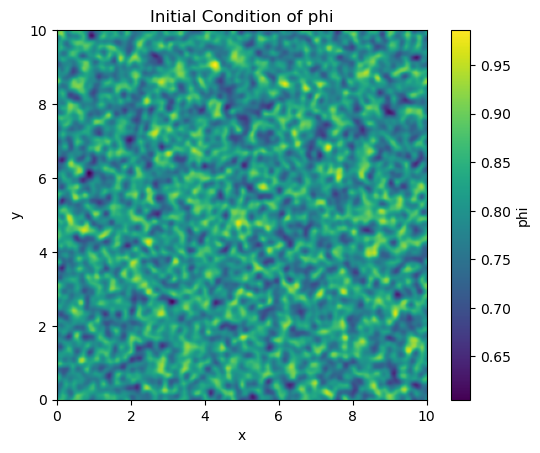

In [10]:
###
#
#   Setup of most parameters for solving the forward problem.
#
###


t_init = 0 # initial time
t_final = 100 # final time
dt = 0.001 # initial guess for time step (I implemented an adaptive time-stepping).

t = 0 # initialize time

phi_array = generate_phi0(toplot=True) # generate initial state for phi.
phi0 = np.copy(phi_array)

s_array = np.zeros((n+1,n+1)) # the depletion s as in eq.3 in the erosion paper. For now just set to 0 everywhere.

# Parameters for adaptive time-stepping (for more details see below)
e_max = 1E-5
r_dec = 0.9
r_inc = 1.1
r_min = 1/3
r_max = 3


widddth_lh = 2*epsilon_lh
widddth_rh = 2*epsilon_rh

# The sum of the integral of the flux over the boundary and the depletion has to equal 0, so q_max_lh * widddth_lh + q_max_rh * widddth_rh + \int d^2 x s(x) == 0.
#     Note: so far I have always set s = 0, hence the division by widddth_lh and widddth_rh.
#     Note2: also, one could consider the case where the flux over the boundary is not constant, then one would have to properly integrate.
q_max_lh = 0.5/widddth_lh
q_max_rh = 0.5/widddth_rh

# The flux will start at 0 and will linearly increase in time until it reaches q_max_lh after the time t_rampup
t_rampup = 10
q_in0_lh = q_max_lh/t_rampup
q_in0_rh = q_max_rh/t_rampup


In [11]:
# initializing tt1,tt2 to keep track of duration tt2-tt1 of a single iteration in the below for-loop.
tt1 = 0
tt2 = 0

# directory to save figures in (to create movie of erosion).
frames_dir = "sim_res-3"
os.makedirs(frames_dir, exist_ok=True)

step = 0

while t < t_final:
    phi_old = phi_array # save previous phi_array in case adaptive time stepping rejects update of phi_array.
    
    # at every 10th iteration, print the iteration step, the current time step dt, 
    # the total time t that has passed and the time (tt2 - tt1) it takes for a single iteration of the for-loop.
    if np.mod(step,10)==0:
        print("Step:", step, dt, t, tt2 -tt1)
        plt.figure()
        plt.imshow(phi_array,vmin=0,vmax=1)
        plt.colorbar()
        plt.savefig(os.path.join(frames_dir, f"frame_{step:03d}.png"))
        plt.close()
        
    tt1 = time.time()
    
    # do a FEM step.
    p, dp_dx0, dp_dx1 = get_p_information(phi_array,t,s_array)

    # implementation of adaptive time stepping as described on p.12 of the SI of the erosion paper.
    rhs_p0 = - phi_array * np.maximum(0,dp_dx0**2 + dp_dx1**2 - psi(convolve_optimized(phi_array)))    
    phi_np1 = phi_array + dt *rhs_p0
    phi_np12 = phi_array + 1/2 * dt * rhs_p0
    
    if np.any(phi_np12 < 0):
        # just set it to some very large value.
        e_np1 = 100000
        
    else:
        p, dp_dx0, dp_dx1 = get_p_information(phi_array,t + dt/2,s_array)
        rhs_p12 = - phi_np12 * np.maximum(0,dp_dx0**2 + dp_dx1**2 - psi(convolve_optimized(phi_np12)))
        phihat_1 = phi_np12 + dt/2 * rhs_p12
        e_np1 = np.sqrt(1/((n*e_max)**2) * np.sum((phi_np1 - phihat_1)**2))


    if e_np1 < 1:
        phi_array = 2*phihat_1 - phi_np1
        if np.any(phi_array) < 0:
            phi_array = phi_old
            dt = r_dec*dt
        else:
            t = t + dt
            dt = r_inc*dt
    else:
        dt = np.maximum(r_min,np.minimum(r_max,r_dec/np.sqrt(e_np1))) * dt
    
    tt2 = time.time()
    step += 1




Step: 0 0.001 0 0
Step: 10 0.002593742460100002 0.015937424601000005 3.8643276691436768
Step: 20 0.006727499949325611 0.057274999493256054 4.795264482498169
Step: 30 0.007856904934087123 0.104259351875619 4.296840667724609
Step: 40 0.007072927404235635 0.14706298918761004 4.37961483001709
Step: 50 0.008485878762801045 0.20067980630221488 4.36811900138855
Step: 60 0.010259388120626729 0.26096877633321175 5.379497766494751
Step: 70 0.009381889900465895 0.31744289504344747 4.218121528625488
Step: 80 0.010744637599589879 0.3871159287923907 4.471665620803833
Step: 90 0.012012612316635684 0.46017458065979117 4.559484243392944
Step: 100 0.009792673555356677 0.5222795127261197 4.980409860610962
Step: 110 0.010552808517558875 0.5933740837345923 4.793853044509888
Step: 120 0.011227230176554243 0.6629825846372133 8.73320198059082
Step: 130 0.008959394640232717 0.7203319526586084 5.433852434158325
Step: 140 0.0096593202696077 0.7851676704051376 5.2567973136901855
Step: 150 0.010495834818734544 0.8